In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import joblib
import time
from lb2jpsil import fit_utils, lorentz
from scipy import optimize, integrate
from sklearn import metrics

In [2]:
## Self explanatory
save_plots = True

## Toggle plot titles (off for thesis and papers, generally speaking)
show_titles = False

## Toggle plot grid
show_grid = False

## Black and white?
black_and_white = False

## Drop event if DTF_FixJPsiLambda failed?
dtf_success = True

## Veto physical background
b0_veto = True

In [3]:
saved_models = {
    ## BALANCE
    ## Higher overtraining. Slightly better performance in test (fractions of percentage)
    'sachiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.010,
        'max_leaf_nodes' : 200,
        'max_iter' : 5000,
        'soft_threshold': 0.7,
        'hard_threshold': 0.9924
    },
    ## Lower ovetraining. Looks better under K-S test. Slightly worse performance in test (fractions of percentage)
    'shamshel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.7,
        'hard_threshold': 0.985
    },
    ## BKGSKEW
    ## From an overtraining standpoint, this is the better one of the bkgskew
    'ramiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.656
    },
    ## This has quite more overtraining, but loses less signal
    'israfel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.015,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.714
    },
    ## Salvatore's HBDT, for performance comparison.
    ## Somewhat similar to israfel, does not match his original HBDT
    'sandalphon': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.01,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.637
    }
}

In [4]:
## Either one of the names in list(saved_models) or 'temp' for custom new model
model_to_use = 'shamshel'

if model_to_use in saved_models:
    daughter_momenta = saved_models[model_to_use]['daughter_momenta']
    dataset_type = saved_models[model_to_use]['dataset_type']
    training_params = {key: saved_models[model_to_use][key] for key in ['learning_rate', 'max_leaf_nodes', 'max_iter']}
    hard_threshold = saved_models[model_to_use]['hard_threshold']
elif model_to_use == 'temp':
    ## Proton and pion momenta
    ## 'VF': use VF momenta
    ## 'DTF': use DTF momenta w/ JPsi m.c.
    ## 'DTFL': use DTF momenta w/ JPsi and Lambda m.c.
    ## 'NO': don't use any momenta for Lambda daughter particles
    daughter_momenta = 'DTF'

    ## Two options:
    ## 'balance': same number of training events for signal and bkg
    ## 'bkgskew' uses 4 mln events of bkg, 500k of signal
    dataset_type = 'bkgskew'

    training_params = {
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 5000
    }
    
    hard_threshold = 0.9
else:
    raise ValueError

In [5]:
if dataset_type not in ['balance', 'bkgskew']:
    raise ValueError

In [6]:
if daughter_momenta == 'VF':
    p_momenta = ['p_PT', 'p_PZ']
    pim_momenta = ['pim_PT', 'pim_PZ']
elif daughter_momenta == 'DTF':
    p_momenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pim_momenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughter_momenta == 'DTFL':
    p_momenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pim_momenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughter_momenta == 'NO':
    p_momenta = []
    pim_momenta = []
else:
    raise ValueError(daughter_momenta + " is not a valid option for momenta usage.")

In [7]:
if dataset_type == 'balance':
    dataset_suffix = 'BAL'
else:
    dataset_suffix = 'SKEW'

classifier_dump_filename = (
    'HBDT_'
    + daughter_momenta
    + '_' + str(training_params['learning_rate'])
    + '_' + str(training_params['max_leaf_nodes'])
    + '_' + str(training_params['max_iter'])
    + '_' + dataset_suffix
)

classifier_dump_filename

'HBDT_DTF_0.003_100_2500_BAL'

In [8]:
## Create plots directory, if missing
repo_dir = str(pathlib.Path.home()) + '/lambda-emdm-measurement/'

plot_directory = (
    repo_dir + 'plots/'
    + 'invariant_mass_fits/'
)

state_directory = str(pathlib.Path.home()) + '/classifier-studies/' + '20_HBDT/' + 'saved_states/'

pathlib.Path(plot_directory).mkdir(parents=True, exist_ok=True)

In [9]:
path_to_hd5_files = str(pathlib.Path.home()) + '/data/'
input_mc = path_to_hd5_files + 'LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'
input_data = path_to_hd5_files + 'LHCbData_2016-2017-2018_MagUpDown_Dimuon_Ttracks_v2.h5'

# Monte Carlo data

In [10]:
df_reco = pd.read_hdf(input_mc, key='LHCbMC_Lb')
df_truth = pd.read_hdf(input_mc, key='LHCbMCTruth_Lb')
df_mc = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
df_mc = df_mc.loc[(df_mc['MC_key'] >= 0) & (df_mc['Rec_key'] >= 0)]

del(df_reco, df_truth)

## Armenteros-Podolanski
Best before prefilters.

In [11]:
def scalar_product(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]

In [12]:
def norm(v):
    return np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)

In [13]:
## Compute variables needed for Armenteros-Podolanski plots
def compute_momentum_asymmetry(
    df: pd.DataFrame, # The DataFrame that will be modified
    mother: str,      # Symbol of the mother: L or KS0
    daughter_1: str,  # Symbol of the conventionally positive daughter
    daughter_2: str,  # Symbol of the conventionally negative daughter
    prefix: str,      # Usually either 'MCTRUTH_' or 'DTF_FixJPsi_'
):

    for coord in ['X', 'Y', 'Z']:
        df[f'{prefix}{mother}_P{coord}'] = df[f'{prefix}{daughter_1}_P{coord}'] + df[f'{prefix}{daughter_2}_P{coord}']

    mother_uv = lorentz.unit_vector(np.array([df[f'{prefix}{mother}_PX'], df[f'{prefix}{mother}_PY'], df[f'{prefix}{mother}_PZ']]))
    part1_p = np.array([df[f'{prefix}{daughter_1}_PX'], df[f'{prefix}{daughter_1}_PY'], df[f'{prefix}{daughter_1}_PZ']])
    part2_p = np.array([df[f'{prefix}{daughter_2}_PX'], df[f'{prefix}{daughter_2}_PY'], df[f'{prefix}{daughter_2}_PZ']])

    part1_pL = scalar_product(part1_p, mother_uv)
    part2_pL = scalar_product(part2_p, mother_uv)

    part1_pT = part1_p - part1_pL * mother_uv
    part2_pT = part2_p - part2_pL * mother_uv

    part1_pT_norm = norm(part1_pT)
    part2_pT_norm = norm(part2_pT)

    df[f'{prefix}pL1'] = part1_pL
    df[f'{prefix}pL2'] = part2_pL
    df[f'{prefix}pT1'] = part1_pT_norm
    df[f'{prefix}pT2'] = part2_pT_norm
    
    df[f'{prefix}p_asymm'] = (df[f'{prefix}pL1'] - df[f'{prefix}pL2'])/(df[f'{prefix}pL1'] + df[f'{prefix}pL2'])

In [14]:
df_mc_norm = df_mc.loc[df_mc['MCTRUTH_L_ID']  == 3122].copy()
df_mc_bar = df_mc.loc[df_mc['MCTRUTH_L_ID']  == -3122].copy()

del(df_mc)

compute_momentum_asymmetry(df_mc_norm, 'L', 'p', 'pim', 'MCTRUTH_')
compute_momentum_asymmetry(df_mc_bar, 'L', 'pim', 'p', 'MCTRUTH_')
compute_momentum_asymmetry(df_mc_norm, 'L', 'p', 'pim', 'DTF_FixJPsi_')
compute_momentum_asymmetry(df_mc_bar, 'L', 'pim', 'p', 'DTF_FixJPsi_')

df_mc = pd.concat([df_mc_norm, df_mc_bar])

del(df_mc_norm, df_mc_bar)

/home/adegenna/lhcb-lb2jpsil/lb2jpsil/lorentz.py:39: RuntimeWarning: overflow encountered in square
  mag = np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)
/home/adegenna/apollo/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


In [15]:
armenteros_cuts = (abs(df_mc['DTF_FixJPsi_p_asymm']) > 0.5)

## Prefilters

In [16]:
def p_modulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

In [17]:
def transverse_p_modulus(px, py):
    return np.sqrt(px**2 + py**2)

In [18]:
jpsi_pdg_mass = 3096.900
b0_pdg_mass = 5279.61
b0_veto_threshold = 70

In [19]:
pion_p_cuts = (
    (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) > 2000)
    & (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) < 5e5)
)

proton_p_cuts = (
    (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) > 10000)
    & (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) < 5e5)
)

proton_pt_cuts = transverse_p_modulus(df_mc['p_PX'], df_mc['p_PY']) > 400

lambda_m_cuts = (df_mc['L_M'] > 600) & (df_mc['L_M'] < 1500)
lambda_mm_cuts = df_mc['L_MM'] < 1500
lambda_z_cuts = (df_mc['L_ENDVERTEX_Z'] > 5500) & (df_mc['L_ENDVERTEX_Z'] < 8500)
lambda_dira_cuts = df_mc['L_BPVDIRA'] > 0.9999
lambda_ipchi2_cuts = df_mc['L_BPVIPCHI2'] < 200
lambda_vdchi2_cuts = df_mc['L_BPVVDCHI2'] < 2e7
lambda_chi2_cuts = df_mc['L_VFASPF_CHI2_VDOF'] < 750
lambda_pt_cuts = transverse_p_modulus(df_mc['L_PX'], df_mc['L_PY']) > 450

jpsi_m_cuts = abs(df_mc['Jpsi_M'] - jpsi_pdg_mass) < 90

lambdab_m_cuts = df_mc['Lb_M'] < 8500
lambdab_dira_cuts = abs(df_mc['Lb_BPVDIRA']) > 0.99
lambdab_ipchi2_cuts = df_mc['Lb_BPVIPCHI2'] < 1750
lambdab_chi2_cuts = df_mc['Lb_VFASPF_CHI2_VDOF'] < 150

dtf_success_cuts = df_mc['DTF_FixJPsiLambda_status'] == 'Success'

b0_veto_cuts = (df_mc['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_mc['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

In [20]:
pre_selection_cuts = (
    pion_p_cuts &
    proton_p_cuts &
    proton_pt_cuts &
    lambda_m_cuts &
    lambda_mm_cuts &
    lambda_z_cuts &
    lambda_dira_cuts &
    lambda_ipchi2_cuts &
    lambda_vdchi2_cuts &
    lambda_chi2_cuts &
    lambda_pt_cuts &
    jpsi_m_cuts &
    lambdab_m_cuts &
    lambdab_dira_cuts &
    lambdab_ipchi2_cuts &
    lambdab_chi2_cuts
)

if dtf_success:
    pre_selection_cuts = pre_selection_cuts & dtf_success_cuts
    
if b0_veto:
    pre_selection_cuts = pre_selection_cuts & b0_veto_cuts & armenteros_cuts

df_mc[pre_selection_cuts]

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,MCTRUTH_pT2,MCTRUTH_p_asymm,DTF_FixJPsi_L_PX,DTF_FixJPsi_L_PY,DTF_FixJPsi_L_PZ,DTF_FixJPsi_pL1,DTF_FixJPsi_pL2,DTF_FixJPsi_pT1,DTF_FixJPsi_pT2,DTF_FixJPsi_p_asymm
Rec_key,,,,,,,,,,,,,,,,,,,,,
17,0.8236,-0.2738,28.986401,-296.374695,-100.123802,5963.561523,-1268.760010,-522.340027,25478.310547,-184.460007,...,93.937080,0.756099,-1419.520630,-477.213348,28305.486328,24814.886719,3530.187256,97.086639,97.086655,0.750914
41,0.7544,-0.1392,26.808500,-62.578999,128.441696,7157.107422,-717.020020,1667.319946,91921.820312,-260.179993,...,99.919182,0.671029,-984.426392,1994.116333,110634.273438,92372.523438,18284.091797,106.371834,106.371925,0.669535
56,1.0630,-0.1569,14.631200,-16.393600,-267.315704,7429.070312,19.139999,-1164.579956,32903.449219,-108.959999,...,98.857040,0.724818,-93.952682,-1448.677734,40345.343750,34826.769531,5544.684570,107.576645,107.576622,0.725317
83,0.3591,0.5208,54.601398,-7.069900,3.450100,207.821304,-2133.159912,839.080017,47703.500000,-462.730011,...,99.478012,0.718243,-2615.015137,1006.504700,55888.726562,47921.796875,8037.131836,103.115486,103.115593,0.712749
91,0.9491,-0.0581,-30.706400,242.386597,237.635101,7576.537598,1416.609985,1302.680054,44654.218750,331.989990,...,92.522087,0.620879,1880.235962,1846.400513,59283.871094,48164.605469,11177.802734,91.445198,91.445213,0.623278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366291,0.2523,0.1334,-17.926600,-817.936401,-140.679001,6026.893066,-3532.949951,-677.299988,26030.919922,-342.480011,...,71.494530,-0.818516,-3975.477051,-685.319519,29368.472656,2690.543945,26953.699219,94.247925,94.247681,-0.818478
366299,0.5863,0.6149,-3.181600,-54.654301,247.277405,6274.290527,-563.250000,2833.120117,73264.546875,-230.440002,...,93.364586,-0.624548,-865.407776,3862.584473,97907.648438,19042.439453,78945.187500,174.835480,174.835678,-0.611330
366319,0.5569,0.0628,57.432899,120.215797,-371.462097,7690.597168,355.570007,-1350.780029,26500.039062,109.430000,...,85.405006,-0.786906,374.016083,-1162.516602,23818.148438,2931.905273,20917.529297,88.928017,88.928009,-0.754132


# Run 2 data

In [21]:
df_data = pd.read_hdf(input_data, key='LHCbData')

In [22]:
df_data_norm = df_data.loc[df_data['L_ID']  == 3122].copy()
df_data_bar = df_data.loc[df_data['L_ID']  == -3122].copy()

del(df_data)

compute_momentum_asymmetry(df_data_norm, 'L', 'p', 'pim', 'DTF_FixJPsi_')
compute_momentum_asymmetry(df_data_bar, 'L', 'pim', 'p', 'DTF_FixJPsi_')

df_data = pd.concat([df_data_norm, df_data_bar])

del(df_data_norm, df_data_bar)

/home/adegenna/lhcb-lb2jpsil/lb2jpsil/lorentz.py:39: RuntimeWarning: overflow encountered in square
  mag = np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)
/home/adegenna/apollo/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


In [23]:
data_armenteros_cuts = (abs(df_data['DTF_FixJPsi_p_asymm']) > 0.5)

In [24]:
data_dtf_cuts = df_data['DTF_FixJPsiLambda_status'] == 'Success'
data_b0_veto_cuts = (df_data['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_data['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

In [25]:
data_cuts = pd.Series(True, index=df_data.index)

if dtf_success:
    data_cuts = data_cuts & data_dtf_cuts

if b0_veto:
    data_cuts = data_cuts & data_b0_veto_cuts & data_armenteros_cuts

df_data[data_cuts]

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType,DTF_FixJPsi_L_PX,DTF_FixJPsi_L_PY,DTF_FixJPsi_L_PZ,DTF_FixJPsi_pL1,DTF_FixJPsi_pL2,DTF_FixJPsi_pT1,DTF_FixJPsi_pT2,DTF_FixJPsi_p_asymm
4,0.915558,-0.309900,-33.831448,-129.211182,-8.126650,7658.323242,0.9167,-0.3099,-33.824600,-1304.095825,...,39286.671875,T,-1055.202881,-58.673973,62382.078125,52128.335938,10262.697266,70.873154,70.873192,0.671020
6,0.773095,-0.056306,114.457909,-383.886292,302.193207,6857.658691,0.7732,-0.0568,114.455597,-1560.964966,...,36119.546875,T,-1064.505615,805.735901,18590.222656,15408.774414,3229.325195,90.497383,90.497353,0.653471
8,0.884807,-0.175969,11.106417,-4.149683,98.740402,6664.036621,0.8840,-0.1755,11.103200,-116.716331,...,13876.246094,T,-46.955376,810.860046,54658.253906,44887.566406,9776.724609,92.390404,92.390373,0.642299
11,0.814028,-0.150978,12.212524,-56.467518,-96.378815,6115.597168,0.8146,-0.1504,12.209900,-301.223541,...,11319.179688,T,-306.098999,-508.419708,32622.929688,27597.046875,5031.278809,95.502571,95.502548,0.691601
13,0.918995,-0.152144,-51.977928,163.638138,82.477783,7025.245605,0.9182,-0.1515,-51.975300,429.812347,...,9621.284180,T,441.684601,236.875122,19348.632812,14857.055664,4498.067383,231.738876,231.738876,0.535207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43650380,0.866164,0.142529,76.982521,100.253281,14.438453,7088.610352,0.8667,0.1427,76.980598,986.404785,...,15419.535156,T,1013.710266,146.908936,71490.023438,10449.293945,61048.066406,108.323997,108.324005,-0.707701
43650384,0.748758,0.145825,0.127407,131.664886,-187.327164,6005.480469,0.7488,0.1461,0.133800,158.802216,...,105794.734375,T,300.735931,-446.378662,14451.720703,2422.346924,12039.392578,278.814392,278.814392,-0.664999
43650389,0.857475,-0.039423,4.761240,-64.110634,-103.120865,7781.708984,0.8575,-0.0395,4.761600,-330.288788,...,6726.413086,T,-332.229309,-528.093933,39765.664062,4974.741699,34795.816406,4.837950,4.837948,-0.749828
43650395,0.491198,0.347749,-39.003174,462.251770,106.401283,7872.058594,0.4908,0.3479,-39.000198,1023.878113,...,8074.763184,T,751.082825,172.571533,12868.384766,2345.935791,10545.504883,11.243641,11.243685,-0.636048


# Further data manipulation
## Add derived variables

In [26]:
def add_derived_variables(
    df: pd.DataFrame
) -> None:
    df['p_PT'] = transverse_p_modulus(df['p_PX'], df['p_PY'])
    df['DTF_FixJPsi_p_PT'] = transverse_p_modulus(df['DTF_FixJPsi_p_PX'], df['DTF_FixJPsi_p_PY'])
    df['DTF_FixJPsiLambda_p_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_p_PX'], df['DTF_FixJPsiLambda_p_PY'])
    df['pim_PT'] = transverse_p_modulus(df['pim_PX'], df['pim_PY'])
    df['DTF_FixJPsi_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsi_pim_PX'], df['DTF_FixJPsi_pim_PY'])
    df['DTF_FixJPsiLambda_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_pim_PX'], df['DTF_FixJPsiLambda_pim_PY'])
    df['Jpsi_PT'] = transverse_p_modulus(df['Jpsi_PX'], df['Jpsi_PY'])
    
    dtf_success_mapper = {
        'Success': 0.0,
        'Failed': 1.0,
        'NonConverged': 3.0
    }

    df.replace({'DTF_FixJPsi_status': dtf_success_mapper}, inplace=True)
    df.replace({'DTF_FixJPsiLambda_status': dtf_success_mapper}, inplace=True)

In [27]:
add_derived_variables(df_mc)
add_derived_variables(df_data)

## Drop based on prefilters

In [28]:
df_mc.drop(df_mc[~pre_selection_cuts].index, inplace=True)
df_data.drop(df_data[~data_cuts].index, inplace=True)

# HBDT

In [29]:
saved_state_file = state_directory + classifier_dump_filename + '.joblib'
HBDT = joblib.load(saved_state_file)

In [30]:
fixed_features = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

features = p_momenta + pim_momenta + fixed_features

In [31]:
tick = time.perf_counter()
mc_predicted = HBDT.predict_proba(df_mc.loc[:, features].to_numpy())[:,1]
tock = time.perf_counter()
print(f"MC events predicted in {(tock - tick):0.4f} seconds.")

MC events predicted in 0.7317 seconds.


In [32]:
tick = time.perf_counter()
data_predicted = HBDT.predict_proba(df_data.loc[:, features].to_numpy())[:,1]
tock = time.perf_counter()
print(f"Data events predicted in {(tock - tick)/60:0.4f} minutes.")

Data events predicted in 4.5981 minutes.


In [33]:
df_mc['HBDT'] = mc_predicted
df_data['HBDT'] = data_predicted

In [34]:
del(mc_predicted, data_predicted)

## Remove events not passing the threshold

In [35]:
mc_pass_threshold = df_mc['HBDT'] > hard_threshold
data_pass_threshold = df_data['HBDT'] > hard_threshold

In [36]:
df_mc.drop(df_mc[~mc_pass_threshold].index, inplace=True)
df_data.drop(df_data[~data_pass_threshold].index, inplace=True)

## Remove events outside of the relevant mass windows

In [37]:
lower_limit_mass_Lb = 5000
upper_limit_mass_Lb = 6200

mc_Lb_invmass_cut = (
    (df_mc['DTF_FixJPsiLambda_Lb_M'] > lower_limit_mass_Lb)
    & (df_mc['DTF_FixJPsiLambda_Lb_M'] < upper_limit_mass_Lb)
)
data_Lb_invmass_cut = (
    (df_data['DTF_FixJPsiLambda_Lb_M'] > lower_limit_mass_Lb)
    & (df_data['DTF_FixJPsiLambda_Lb_M'] < upper_limit_mass_Lb)
)

In [38]:
df_mc.drop(df_mc[~mc_Lb_invmass_cut].index, inplace=True)
df_data.drop(df_data[~data_Lb_invmass_cut].index, inplace=True)

In [39]:
df_mc

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsi_pT2,DTF_FixJPsi_p_asymm,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
Rec_key,,,,,,,,,,,,,,,,,,,,,
56,1.0630,-0.1569,14.631200,-16.393600,-267.315704,7429.070312,19.139999,-1164.579956,32903.449219,-108.959999,...,107.576622,0.725317,1677.147461,1222.470947,1180.346313,260.234802,254.823410,243.301285,2582.130859,0.986191
91,0.9491,-0.0581,-30.706400,242.386597,237.635101,7576.537598,1416.609985,1302.680054,44654.218750,331.989990,...,91.445213,0.623278,3250.556641,2059.110596,2138.758789,413.884552,578.251099,858.173340,1172.271973,0.990708
93,0.8698,-0.0087,-61.167301,5.258500,178.656799,7477.866211,134.649994,1566.119995,66334.351562,-87.529999,...,93.933685,0.616246,1914.452026,1541.024048,1483.825928,364.727753,379.656891,364.195160,1196.638428,0.989228
118,1.1396,-0.2901,6.363200,23.924900,-151.806702,7417.714844,183.149994,-964.179993,51779.789062,0.160000,...,90.671173,0.745712,1158.645996,962.766296,981.719482,242.024384,239.956055,246.622147,3400.177246,0.987851
150,1.0411,-0.3097,-19.698900,858.356018,-212.597198,6700.881348,5178.000000,-1212.050049,39903.679688,928.630005,...,210.187805,0.663270,7280.269043,6886.478516,5292.452637,876.763123,1170.399292,961.289429,5073.340332,0.987371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366203,0.4704,-0.4386,-19.485800,-111.744202,-138.079300,6616.266602,-747.200012,-836.380005,39088.210938,-73.599998,...,81.999931,-0.602113,1158.625732,1024.985840,1049.035034,297.850037,277.218781,286.209717,2787.019287,0.987928
366213,0.6122,-0.0708,87.435204,-438.150391,-214.334595,6468.198730,-3648.800049,-1744.800049,54030.121094,-607.150024,...,85.426590,-0.749597,3792.759766,3998.337891,4049.203369,903.033020,660.581848,681.052551,2518.792969,0.995600
366268,0.9817,-0.2910,-13.832300,402.671509,16.624701,8214.584961,1634.530029,26.360001,33188.000000,113.620003,...,44.865894,-0.877438,2154.688965,1975.448608,1626.364014,105.307137,119.006645,118.100471,2818.800293,0.986714


In [40]:
df_data

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsi_pT2,DTF_FixJPsi_p_asymm,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
1243,0.570611,-0.048790,9.819603,-219.870300,-23.170826,6890.049316,0.5706,-0.0484,9.826700,-2135.995850,...,59.753120,0.846256,2118.871582,2296.816406,2250.925537,25.952250,128.293900,133.510849,1713.736938,0.991741
3224,1.287199,-0.047269,-13.550518,386.773163,260.747986,7545.715332,1.2871,-0.0472,-13.549400,2982.429932,...,48.543789,0.611645,3160.910889,2734.306152,2800.330078,681.059753,625.595215,723.562500,1597.382690,0.989822
8572,1.059898,-0.769249,65.935455,190.492157,-194.708862,7476.943848,1.0599,-0.7692,65.934799,1988.378540,...,123.441956,0.625549,2134.475342,2105.480957,1894.416626,632.940308,622.114441,538.227722,6145.642090,0.996070
9103,0.655593,-0.114162,30.517849,-163.553940,-17.964283,7608.963867,0.6584,-0.1147,30.486601,-2759.609619,...,133.466278,0.549414,1460.278320,2271.128906,2496.541992,706.247681,767.638123,642.176880,3088.032715,0.992878
12009,-0.100932,-1.279418,-101.201027,-429.141205,-611.286133,6669.682129,-0.1009,-1.2794,-101.201500,-2201.564697,...,279.522491,0.851565,4299.791504,6110.213867,4161.294922,408.936584,405.340912,316.363739,10866.897461,0.988911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43637515,0.912453,0.143902,14.692216,-266.370941,-54.186954,6374.009277,0.9126,0.1440,14.698300,-1885.018188,...,156.545013,-0.671510,1956.730957,1912.784546,1728.373291,91.749657,209.985382,234.235077,2204.032471,0.989561
43640202,0.606850,-0.255569,3.714975,-42.871368,-136.398880,6625.701660,0.6068,-0.2556,3.715600,-704.583679,...,184.678680,-0.593358,1902.609863,1317.207764,1112.647095,303.777618,208.493118,181.885315,4554.110352,0.991437
43643898,0.661234,-0.403287,47.950920,46.069107,134.737579,7240.625000,0.6633,-0.4017,47.922600,507.450500,...,101.723274,-0.760893,1201.043457,1601.999023,979.264160,197.984650,190.510666,183.268936,3910.110596,0.990513
43644236,-0.706107,-1.116585,-19.095575,-598.051270,-748.757507,6235.612305,-0.7061,-1.1166,-19.095600,-5272.707520,...,173.479645,-0.535770,6555.232422,5079.992676,5601.033691,1301.919434,1350.152344,1419.455200,7243.634766,0.996143


# Invariant mass fits

In [75]:
## Takes as input a hexstring (doesn't care if with or without the leading hash)
## and an alpha value. Yields a tuple for matplotlib color definition
def hex_to_rgba(hexstring, alpha):
    if hexstring[0] == '#':
        hexstring = hexstring[1:]
    
    #return tuple(int(hexstring[i:i+2], 16) for i in (0, 2, 4))
    return list(int(hexstring[i:i+2], 16)/255 for i in (0, 2, 4)) + [alpha]

In [76]:
plum = '#6e304b'
apricot = '#e2ae6c'
lightplum = '#a37c82'

In [77]:
lambdab_pdg_mass = 5620.2

In [78]:
## Almost zero, but not quite
epsilon = 1e-15

In [79]:
## Double crystal ball parameter dictionary
sig_func = {
     'param_names' : [r'S'  , r'mu' , r'sigma', r'alpha_1', r'n_1', r'alpha_2', r'n_2'],
     'p0'          : [6e4   , 5618   ,  35      , 0.7        ,  3.7  , 0.7        ,    3.7],
     'lb'          : [1e1   , 5000   ,   1      , 0.1        ,  1.5  , 0.1        ,    1.5],
     'ub'          : [1e6   , 6250   , 200      , 5          ,   10  , 5          ,     10]
}

In [80]:
## Dictionary variant for the constrained sig+bkg fit
sig_func_constrained = {
     'param_names' : [ r'S', r'sigma' ],
     'p0'          : [  200,    35    ],
     'lb'          : [    0,     1    ],
     'ub'          : [  1e9,   200    ]
}

In [81]:
## Turn-on exponential dictionary
bkg_func = {
    'param_names' : [r'C',    r'a'],
    'p0' :          [0.09,    0.0008 ],
    'lb' :          [epsilon, epsilon],
    'ub' :          [1e9,     1      ]
}

## $J/\psi \Lambda^0$

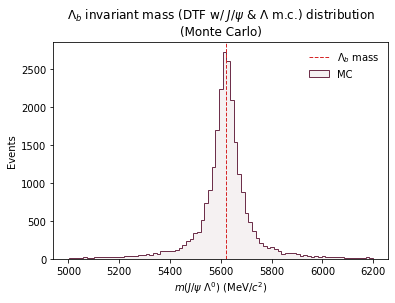

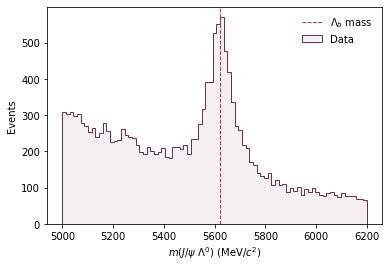

In [82]:
inv_mass_variable = 'DTF_FixJPsiLambda_Lb_M'
inv_mass_variable_title = '$\Lambda_b$ invariant mass (DTF w/ $J/\psi$ & $\Lambda$ m.c.)'
bin_number = 83
basic_filename = 'lambdab_after_hard_hist'

plot_filename = 'MC_' + basic_filename

MC_events, MC_bins, MC_patches = plt.hist(
    df_mc.loc[:, inv_mass_variable],
    histtype='stepfilled', color=hex_to_rgba(lightplum,0.1), edgecolor=plum,
    bins=bin_number, label='MC')

if show_grid:
    plt.grid()
#plt.yscale('log')
plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.title(inv_mass_variable_title + " distribution" + '\n(Monte Carlo)')
plt.axvline(lambdab_pdg_mass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend(frameon=False)
if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')
plt.show()

plot_filename = 'Data_' + basic_filename

data_events, data_bins, data_patches = plt.hist(
    df_data.loc[:, inv_mass_variable],
    histtype='stepfilled', color=hex_to_rgba(lightplum,0.1), edgecolor=plum,
    bins=bin_number, label='Data')

if show_grid:
    plt.grid()
plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel('Events')

if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Real data)')
plt.axvline(lambdab_pdg_mass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend(frameon=False)
if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')
plt.show()

### Simulation

In [83]:
MC_bin_midpoints = (MC_bins[1:] + MC_bins[:-1]) / 2

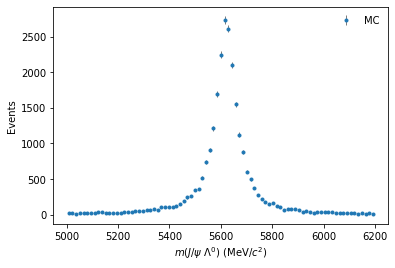

In [84]:
basic_filename = 'lambdab_after_hard_errorbar'
plot_filename = 'MC_' + basic_filename

if black_and_white:
    data_color = 'black'
    error_bar_color = 'black'
    error_line_width = 1.
    
    fit_color = 'black'
    fit_linestyle = '--'
    fit_line_width = 1.
    
    pull_color = 'black'
    lambda_pdg_color = 'black'
else:
    data_color = 'tab:blue'
    error_bar_color = 'black'
    error_line_width = .5
    
    fit_color = 'tab:orange'
    fit_linestyle = None
    fit_line_width = None
    
    pull_color = 'tab:gray'
    lambda_pdg_color = 'tab:red'

plt.errorbar(x=MC_bin_midpoints,
             y=MC_events,
             yerr=np.sqrt(MC_events),
             linestyle='',
             marker='.',
             color=data_color, ecolor=error_bar_color,
             elinewidth=error_line_width,
             label='MC')

if show_grid:
    plt.grid()
    
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Monte Carlo)')

plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [85]:
MC_param_best, MC_param_covmatrix = optimize.curve_fit(
    f=fit_utils.crystal_ball_double_norm,
    xdata=MC_bin_midpoints,
    ydata=MC_events,
    p0=sig_func['p0'],
    sigma=np.sqrt(MC_events),
    bounds=(
        sig_func['lb'],
        sig_func['ub']
    )
)

In [86]:
def pdg_round(value, error) :
    "Given a value and an error, round and format them according to the PDG rules for significant digits"
    def three_digits(value) :
        "extract the three most significant digits and return them as an int"
        return int(("%.2e"%float(error)).split('e')[0].replace('.','').replace('+','').replace('-',''))
    def n_significant_digits(three_digits) :
        assert three_digits<1000,"three digits (%d) cannot be larger than 10^3"%three_digits
        if three_digits<101 : return 2 # not sure
        elif three_digits<356 : return 2
        elif three_digits<950 : return 1
        else : return 2
    def frexp10(value) :
        "convert to mantissa+exp representation (same as frex, but in base 10)"
        valueStr = ("%e"%float(value)).split('e')
        return float(valueStr[0]), int(valueStr[1])
    def n_digits_value(expVal, expErr, nDigitsErr) :
        "compute the number of digits we want for the value, assuming we keep nDigitsErr for the error"
        return expVal-expErr+nDigitsErr
    def format_value(value, exponent, nDigits, extraRound=0) :
        "Format the value; extraRound is meant for the special case of three_digits>950"
        roundAt = nDigits-1-exponent - extraRound
        nDec = roundAt if exponent<nDigits else 0
        nDec = max([nDec, 0])
        return ('%.'+str(nDec)+'f')%round(value,roundAt)
    tD = three_digits(error)
    nD = n_significant_digits(tD)
    expVal, expErr = frexp10(value)[1], frexp10(error)[1]
    extraRound = 1 if tD>=950 else 0
    return (format_value(value, expVal, n_digits_value(expVal, expErr, nD), extraRound),
            format_value(error,expErr, nD, extraRound))

In [87]:
MC_param_names = sig_func['param_names']
MC_param_error = np.sqrt(np.diag(MC_param_covmatrix))
for name, best, error in zip(MC_param_names, MC_param_best, MC_param_error):
    best_rounded, error_rounded = pdg_round(best, error)
    print(name, ":\t\t", best_rounded, "\t+-\t", error_rounded)

S :		 365900 	+-	 3100
mu :		 5620.2 	+-	 0.6
sigma :		 36.9 	+-	 1.0
alpha_1 :		 0.99 	+-	 0.04
n_1 :		 2.44 	+-	 0.12
alpha_2 :		 1.01 	+-	 0.04
n_2 :		 2.69 	+-	 0.15


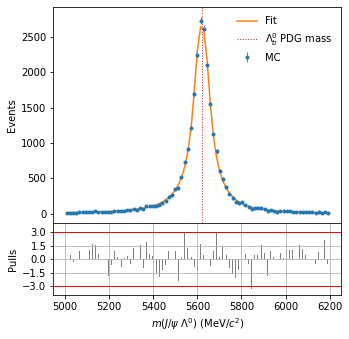

In [88]:
basic_filename = 'lambdab_hard_fit'
plot_filename = 'MC_' + basic_filename

if black_and_white:
    data_color = 'black'
    error_bar_color = 'black'
    error_line_width = 1.
    
    fit_color = 'black'
    fit_linestyle = '--'
    fit_line_width = 1.
    
    pull_color = 'black'
    lambda_pdg_color = 'black'
else:
    data_color = 'tab:blue'
    error_bar_color = 'black'
    error_line_width = .5
    
    fit_color = 'tab:orange'
    fit_linestyle = None
    fit_line_width = None
    
    pull_color = 'tab:gray'
    lambda_pdg_color = 'tab:red'

## Invariant mas fit plot
fig = plt.figure(figsize=(5, 5))
frame_fit = fig.add_axes((.1,.3,.8,.6))
plt.errorbar(x=MC_bin_midpoints,
             y=MC_events,
             yerr=np.sqrt(MC_events),
             linestyle='',
             marker='.',
             color=data_color, ecolor=error_bar_color,
             elinewidth=error_line_width,
             label='MC')

plt.plot(MC_bin_midpoints,
         fit_utils.crystal_ball_double_norm(MC_bin_midpoints, *MC_param_best),
         color=fit_color, linestyle=fit_linestyle, linewidth=fit_line_width,
         label='Fit')

plt.axvline(lambdab_pdg_mass, linestyle='dotted', color=lambda_pdg_color, linewidth=1, label='$\Lambda_b^0$ PDG mass')

if show_grid:
    plt.grid()
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Monte Carlo)')

plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

## Pulls plot
frame_pulls = fig.add_axes((.1,.1,.8,.2))
plt.bar(x=MC_bin_midpoints,
        height=(MC_events - fit_utils.crystal_ball_double_norm(MC_bin_midpoints, *MC_param_best))/np.sqrt(MC_events),
        width=4,
        color=pull_color)
if not black_and_white:
    plt.axhline(3, color='red', linewidth=1)
    plt.axhline(-3, color='red', linewidth=1)
plt.ylim((-4,4))
plt.grid()
plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel("Pulls")
plt.yticks([-3,-1.5,0,1.5,3])

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')
    plt.savefig(plot_directory + plot_filename + '.png', bbox_inches='tight', dpi=150)

plt.show()

In [89]:
(
    _,
    mu_constr,
    _,
    alpha_1_constr,
    n_1_constr,
    alpha_2_constr,
    n_2_constr
) = MC_param_best

### Run 2 data

In [90]:
data_bin_midpoints = (data_bins[1:] + data_bins[:-1]) / 2

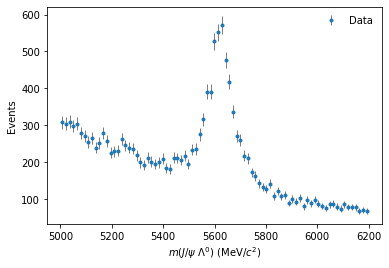

In [91]:
basic_filename = 'lambdab_after_soft_errorbar'
plot_filename = 'data_' + basic_filename

if black_and_white:
    data_color = 'black'
    error_bar_color = 'black'
    error_line_width = 1.
    
    fit_sig_color = 'black'
    fit_sig_linestyle = '--'
    fit_sig_line_width = 1.
    fit_bkg_color = 'black'
    fit_bkg_linestyle = '-.'
    fit_bkg_line_width = 1.
    
    pull_color = 'black'
    lambda_pdg_color = 'black'
else:
    data_color = 'tab:blue'
    error_bar_color = 'black'
    error_line_width = .5
    
    fit_sig_color = 'tab:orange'
    fit_sig_linestyle = None
    fit_sig_line_width = None
    fit_bkg_color = 'tab:green'
    fit_bkg_linestyle = None
    fit_bkg_line_width = None
    
    pull_color = 'tab:gray'
    lambda_pdg_color = 'tab:red'

plt.errorbar(x=data_bin_midpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='',
             marker='.',
             color=data_color, ecolor=error_bar_color,
             elinewidth=error_line_width,
             label='Data')

if show_grid:
    plt.grid()
    
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Run 2 data)')

plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [92]:
## This is the complete fit function, sum of:
## 1. A crystal_ball_double_norm with fixed parameters (to MC fit results) apart from normalization S.
## 2. An exponential with free parameters C (normalization) and a (coefficient, as in exp[-a*x])
def sig_bkg_fit_function(x, S, sigma, C, a):
    ## Fixed parameters
    mu = mu_constr
    alpha1 = alpha_1_constr
    n1 = n_1_constr
    alpha2 = alpha_2_constr
    n2 = n_2_constr
    
    signal = fit_utils.crystal_ball_double_norm(x, S, mu, sigma, alpha1, n1, alpha2, n2)
    background = fit_utils.exp(x, C, a)
    
    return signal + background

In [93]:
data_param_best, data_param_covmatrix = optimize.curve_fit(
    f=sig_bkg_fit_function,
    xdata=data_bin_midpoints,
    ydata=data_events,
    p0=sig_func_constrained['p0'] + bkg_func['p0'],
    sigma=np.sqrt(data_events),
    bounds=(
        sig_func_constrained['lb'] + bkg_func['lb'],
        sig_func_constrained['ub'] + bkg_func['ub']
    )
)

In [94]:
data_param_names = sig_func_constrained['param_names'] + bkg_func['param_names']
data_param_error = np.sqrt(np.diag(data_param_covmatrix))
for name, best, error in zip(data_param_names, data_param_best, data_param_error):
    best_rounded, error_rounded = pdg_round(best, error)
    print(name, ":\t\t", best_rounded, "\t+-\t", error_rounded)

S :		 65600 	+-	 1800
sigma :		 41.6 	+-	 1.6
C :		 240000 	+-	 40000
a :		 0.001336 	+-	 0.000029


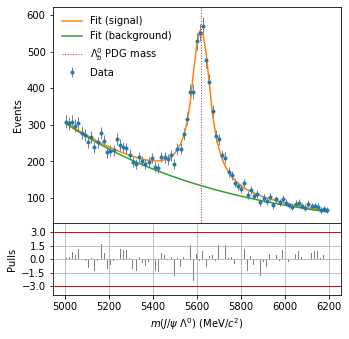

In [95]:
basic_filename = 'lambdab_hard_fit'
plot_filename = 'data_' + basic_filename

if black_and_white:
    data_color = 'black'
    error_bar_color = 'black'
    error_line_width = 1.
    
    fit_sig_color = 'black'
    fit_sig_linestyle = '--'
    fit_sig_line_width = 1.
    fit_bkg_color = 'black'
    fit_bkg_linestyle = '-.'
    fit_bkg_line_width = 1.
    
    pull_color = 'black'
    lambda_pdg_color = 'black'
else:
    data_color = 'tab:blue'
    error_bar_color = 'black'
    error_line_width = .5
    
    fit_sig_color = 'tab:orange'
    fit_sig_linestyle = None
    fit_sig_line_width = None
    fit_bkg_color = 'tab:green'
    fit_bkg_linestyle = None
    fit_bkg_line_width = None
    
    pull_color = 'tab:gray'
    lambda_pdg_color = 'tab:red'

## Invariant mas fit plot
fig = plt.figure(figsize=(5, 5))
frame_fit = fig.add_axes((.1,.3,.8,.6))
plt.errorbar(x=data_bin_midpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='',
             marker='.',
             color=data_color, ecolor=error_bar_color,
             elinewidth=error_line_width,
             label='Data')

plt.plot(data_bin_midpoints,
         sig_bkg_fit_function(data_bin_midpoints, *data_param_best),
         color=fit_sig_color, linestyle=fit_sig_linestyle, linewidth=fit_sig_line_width,
         label='Fit (signal)')
plt.plot(data_bin_midpoints,
         fit_utils.exp(data_bin_midpoints, *data_param_best[2:]),
         color=fit_bkg_color, linestyle=fit_bkg_linestyle, linewidth=fit_bkg_line_width,
         label='Fit (background)')
plt.axvline(lambdab_pdg_mass, linestyle='dotted', color=lambda_pdg_color, linewidth=1, label='$\Lambda_b^0$ PDG mass')
if show_grid:
    plt.grid()
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Run 2 data)')

plt.xlabel("$m(J/\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(loc='upper left', frameon=False)

## Pulls plot
frame_pulls = fig.add_axes((.1,.1,.8,.2))
plt.bar(x=data_bin_midpoints,
        height=(data_events - sig_bkg_fit_function(data_bin_midpoints, *data_param_best))/np.sqrt(data_events),
        width=4,
        color=pull_color)
if not black_and_white:
    plt.axhline(3, color='red', linewidth=1)
    plt.axhline(-3, color='red', linewidth=1)
plt.ylim((-4,4))
plt.grid()
plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel("Pulls")
plt.yticks([-3,-1.5,0,1.5,3])

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')
    plt.savefig(plot_directory + plot_filename + '.png', bbox_inches='tight', dpi=150)

plt.show()

In [96]:
S, sigma, C, a = data_param_best

lower_integration_limit = mu_constr - 3 * sigma
upper_integration_limit = mu_constr + 3 * sigma

print("Integration interval:", ('{0:.5g}'. format(lower_integration_limit), '{0:.5g}'. format(upper_integration_limit)))

Integration interval: ('5495.5', '5744.9')


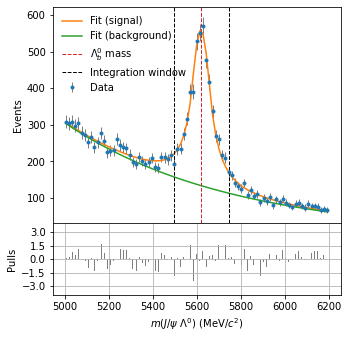

In [97]:
basic_filename = 'lambdab_hard_fit_window'
plot_filename = 'data_' + basic_filename

## Invariant mas fit plot
fig = plt.figure(figsize=(5, 5))
frame_fit = fig.add_axes((.1,.3,.8,.6))
plt.errorbar(x=data_bin_midpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='',
             marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label='Data')

plt.plot(data_bin_midpoints,
         sig_bkg_fit_function(data_bin_midpoints, *data_param_best),
         color='tab:orange',
         label='Fit (signal)')
plt.plot(data_bin_midpoints,
         fit_utils.exp(data_bin_midpoints, *data_param_best[2:]),
         color='tab:green',
         label='Fit (background)')
plt.axvline(lambdab_pdg_mass, linestyle='--', color='tab:red', linewidth=1, label='$\Lambda_b^0$ mass')
plt.axvline(lower_integration_limit, linestyle='--', color='k', linewidth=1)
plt.axvline(upper_integration_limit, linestyle='--', color='k', linewidth=1, label='Integration window')
if show_grid:
    plt.grid()
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Run 2 data)')

plt.xlabel("$m(J/\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

## Pulls plot
frame_pulls = fig.add_axes((.1,.1,.8,.2))
plt.bar(x=data_bin_midpoints,
        height=(data_events - sig_bkg_fit_function(data_bin_midpoints, *data_param_best))/np.sqrt(data_events),
        width=4,
        color='tab:gray')
plt.ylim((-4,4))
plt.grid()
plt.xlabel("$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)")
plt.ylabel("Pulls")
plt.yticks([-3,-1.5,0,1.5,3])

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [98]:
integration_window = (data_bin_midpoints >= lower_integration_limit) & (data_bin_midpoints <= upper_integration_limit)

s = sum(fit_utils.crystal_ball_double_norm(
    data_bin_midpoints[integration_window],
    S, mu_constr, sigma, alpha_1_constr, n_1_constr, alpha_2_constr, n_2_constr
))
b = sum(fit_utils.exp(data_bin_midpoints[integration_window], C, a))

print('Hard threshold:', hard_threshold)
print("s =", s, "\nb =", b)
print("Signal signifance:\t\t", s/np.sqrt(s+b))
print("Signal-to-background ratio:\t", s/b)
print("Signal purity:\t\t\t", s/(s+b))

Hard threshold: 0.985
s = 3586.7704887390137 
b = 2420.5136184692383
Signal signifance:		 46.276925911470805
Signal-to-background ratio:	 1.4818220651067149
Signal purity:			 0.5970702275318027
